In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def custom_read_csv(filename):
    df = pd.read_csv(filename)
    df['date'] = pd.to_datetime(df['date'])
    return df.set_index('date')

In [3]:
# note that all prices are released on Monday, dayofweek = 0
national_price = custom_read_csv('national.csv').dropna()
state_price = custom_read_csv('state.csv').dropna()
state_price = state_price.drop('Unnamed: 10', axis=1).dropna()
city_price = custom_read_csv('city.csv').dropna()
price = pd.concat([national_price, state_price, city_price], axis=1)

In [4]:
# the predictors are relaesed on Friday, add 3 days to align
spot = custom_read_csv('spot.csv').drop('Unnamed: 3', axis=1).dropna()
supply = custom_read_csv('productsupplied.csv').dropna()
stocks = custom_read_csv('stocks.csv').dropna()
predictors = pd.concat([spot, supply, stocks], axis=1)
predictors.index = predictors.index + pd.DateOffset(days=3)

In [5]:
yearly_price = price.national.groupby(price.index.year).median()

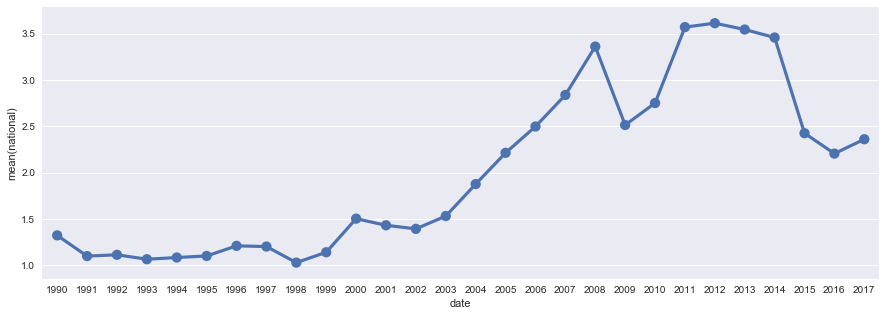

In [6]:
fig, ax = plt.subplots(figsize=(15,5))
sns.pointplot(yearly_price.index.astype(int), yearly_price, ax=ax)

In [7]:
from sklearn.linear_model import LinearRegression

In [110]:
def regress(predictor, response, start, end):
    '''
        helper function to run regression
        predictor: dataframe of predictors
        response: series of response
        start: start year
        end: end year
    '''
    ystart = response.index[response.index.searchsorted('%d-01-01' % start)]
    yend = response.index[response.index.searchsorted('%d-01-01' % (end+1))-1]
    y = response[ystart:yend].values
    
    X = predictor[ystart:yend].values
    
    assert X.shape[0] == y.shape[0], "predictor and response are not the same length"
    
    reg = LinearRegression(normalize=True)
    reg.fit(X, y)
    return (reg.coef_, reg.score(X,y))

In [111]:
regress(predictors, price.national, 1992, 2010)

(array([  5.45798816e-03,   2.02220742e-02,   2.17483207e-05,
          6.67241517e-05,   1.45534393e-06,  -3.89578677e-06]),
 0.97682038305171737)

In [112]:
correls = pd.concat([price.national, predictors], axis=1).rolling(window=250).corr()

In [136]:
correls = correls.loc[(slice(None), 'national'),:].dropna().drop('national', axis=1)

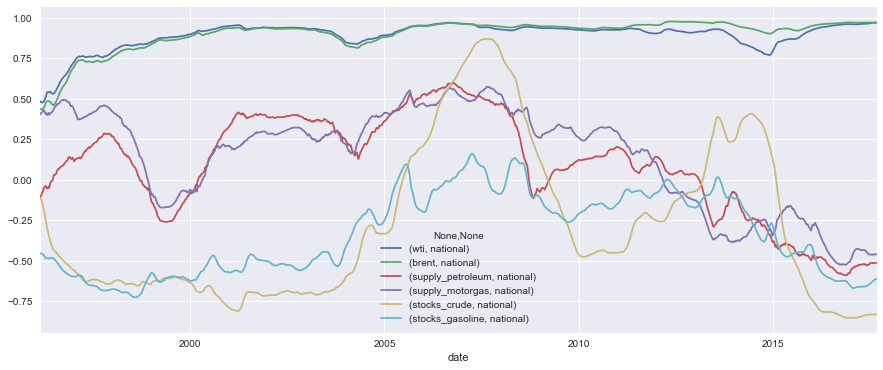

In [171]:
correls.unstack().dropna().plot(figsize=(15,6))
plt.show()